In [50]:
%matplotlib widget
%matplotlib inline

In [51]:
import pandas as pd
from dask import dataframe as dd
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

#### read databases (parquet files don't include agg points)

In [52]:
%%time
#READ DATABASE FOR RANDOM ORIENTATION
df_rand = dd.read_parquet("../instance_files/parquet_files/createdb_iceagg_rand*", engine="pyarrow").compute()

CPU times: user 4.62 s, sys: 494 ms, total: 5.11 s
Wall time: 4.94 s


In [53]:
%%time
#READ DATABASE FOR flat ORIENTATION
df_flat = dd.read_parquet("../instance_files/parquet_files/createdb_iceagg_flat*", engine="pyarrow").compute()

CPU times: user 4.24 s, sys: 469 ms, total: 4.71 s
Wall time: 3.84 s


#### calculate agg aspect ratio, shape, and radius

In [54]:
def shape(a,b,c):
    if (b-c) <= (a-b):
        return 'prolate'
    else:
        return 'oblate'

In [55]:
#speed up shape function 
vfunc = np.vectorize(shape)
df_rand['shape'] = vfunc(df_rand['a'], df_rand['b'], df_rand['c'])
df_rand = df_rand.reset_index()
df_rand.loc[df_rand['shape'] == 'oblate', 'agg_r'] = np.power((np.power(df_rand['a'], 2) * df_rand['c']), (1./3.))
df_rand.loc[df_rand['shape'] == 'prolate', 'agg_r'] = np.power((np.power(df_rand['c'], 2) * df_rand['a']), (1./3.))
#df_rand = df_rand[df_rand.agg_r < 5000]
df_rand['agg_phi'] = df_rand.c/df_rand.a


In [56]:
#speed up shape function 
vfunc = np.vectorize(shape)
df_flat['shape'] = vfunc(df_flat['a'], df_flat['b'], df_flat['c'])
df_flat = df_flat.reset_index()
df_flat.loc[df_flat['shape'] == 'oblate', 'agg_r'] = np.power((np.power(df_flat['a'], 2) * df_flat['c']), (1./3.))
df_flat.loc[df_flat['shape'] == 'prolate', 'agg_r'] = np.power((np.power(df_flat['c'], 2) * df_flat['a']), (1./3.))
df_flat['agg_phi'] = df_flat.c/df_flat.a


In [103]:
df_flat['cplx'].describe().round(2)

count    4872000.00
mean           0.74
std            0.23
min            0.10
25%            0.58
50%            0.81
75%            0.93
max            1.00
Name: cplx, dtype: float64

In [51]:
df_rand['agg_r'].describe().round(2)

count    4872000.00
mean        3426.32
std         7718.75
min            1.19
25%           84.25
50%          536.39
75%         3350.80
max       128528.01
Name: agg_r, dtype: float64

In [93]:
df_flat['agg_r'].describe().round(2)

count    4872000.00
mean        1711.03
std         2997.87
min            0.67
25%           51.28
50%          344.94
75%         2069.44
max        50534.18
Name: agg_r, dtype: float64

In [60]:
#how many monomers comprise the aggs when the agg radius is > 5mm?
#running this cell truncates the df and will lose the aggs > 5000
df_rand = df_rand[df_rand.agg_r > 5000]
df['ncrystals'].describe().round(2)

count    4872000.00
mean          16.00
std            8.37
min            2.00
25%            9.00
50%           16.00
75%           23.00
max           30.00
Name: ncrystals, dtype: float64

## Make bin plots

In [57]:
agg_phi_bins = 20
agg_r_bins = 20

In [38]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df_r.ncrystals.mean())
    return avg_ncrystals


In [39]:
def avg_cplx(df_phi, r_bins):
    avg_cplx = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_cplx.append(np.mean(df_r.cplx))
        
    return avg_cplx


In [40]:
def oblate_prolate(df_phi, r_bins):
    oblates = []
    prolates = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)]
        oblate = df_r['shape'][df_r['shape'] == 'oblate'].count()
        prolate = df_r['shape'][df_r['shape'] == 'prolate'].count()
        oblates.append(oblate)
        prolates.append(prolate)
    return oblates, prolates

In [96]:
def plate_columns_agg(df_phi, r_bins):
    agg_mono_phi = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)]
        agg_mono_plates = df_r['mono_phi'][df_r['mono_phi'] < 1.0].count()
        agg_mono_col = df_r['mono_phi'][df_r['mono_phi'] > 1.0].count()
        #agg_mono_phi.append(agg_mono_plates - agg_mono_col)
        agg_mono_phi.append(agg_mono_plates/(agg_mono_plates+agg_mono_col)*100)
    return agg_mono_phi


In [97]:
def average_radius(df_phi, r_bins):
    avg_radius = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_radius.append(np.mean(df_r.mono_r))
    return avg_radius

In [98]:
df = df_flat
res, phi_bins = pd.qcut(df['agg_phi'], agg_phi_bins, retbins=True)
phi_bin_labs = []
avg_ncrystals=np.empty((len(phi_bins)-1,len(phi_bins)-1))
avg_cplxs=np.empty((len(phi_bins)-1,len(phi_bins)-1))
all_r_bins= np.empty((len(phi_bins),len(phi_bins)))
oblates= np.empty((len(phi_bins)-1,len(phi_bins)-1))
prolates= np.empty((len(phi_bins)-1,len(phi_bins)-1))
shape= np.empty((len(phi_bins)-1,len(phi_bins)-1))
agg_mono_phi = np.empty((len(phi_bins)-1,len(phi_bins)-1))
avg_radius = np.empty((len(phi_bins)-1,len(phi_bins)-1))

for i in range(agg_phi_bins):
    print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f)' %(phi_bins[i],phi_bins[i+1]))
    #return a df that only queries within an aspect ratio bin
    df_phi = df[(df['agg_phi'] > phi_bins[i]) & (df['agg_phi'] < phi_bins[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins = pd.qcut(df_phi.agg_r, agg_r_bins, retbins=True)
    all_r_bins[i,:] = r_bins
    
    #now use those r bins from the output of queried r and phi to find:
    avg_ncrystals[i,:] = query_ncrystals(df_phi, r_bins)
    avg_cplxs[i,:] = avg_cplx(df_phi, r_bins)
    oblates[i,:], prolates[i,:] = oblate_prolate(df_phi, r_bins)
    shape[i,:] = oblates[i,:] - prolates[i,:]
    agg_mono_phi[i,:] = plate_columns_agg(df_phi, r_bins)
    avg_radius[i,:] = average_radius(df_phi, r_bins)
    

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19


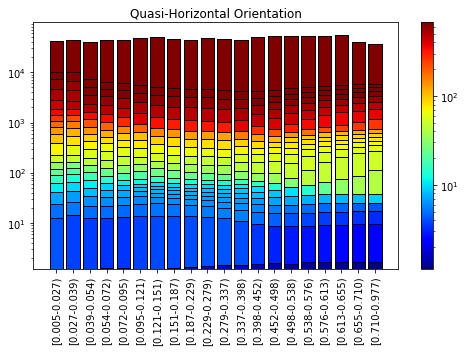

In [91]:
fig, ax = plt.subplots(figsize=(7,5))
cmap = plt.cm.jet
variable = avg_radius
norm = matplotlib.colors.LogNorm(vmin=1.13, vmax=672)

#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))
for i in range(agg_phi_bins): 
    for r in range(agg_r_bins):
        #print(i,r)
        if r != 0:
            plt.bar([i]*20, all_r_bins[i,r+1], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            plt.bar([i]*20, all_r_bins[i,r+1], color=cmap(norm(variable[i,r])), edgecolor='k')
                
plt.yscale('log')
#plt.ylim(1.,10000)

#plt.xticks([])
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
#plt.ylabel("Aggregate Radius Bins")

#plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins") 
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cb, orientation='vertical')
#cbar.ax.set_ylabel('Average Monomer Radius per Bin', orientation='horizontal')
plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation')
plt.tight_layout()
#plt.savefig('../plots/bins_flat_meanmono_r.png', format='png', dpi=300)


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


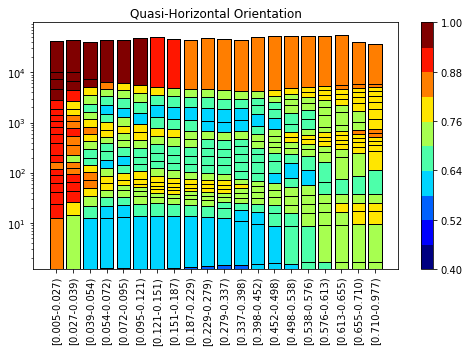

In [99]:
fig, ax = plt.subplots(figsize=(7,5))
cmap = plt.cm.jet
variable = avg_cplxs
norm = matplotlib.colors.Normalize(vmin=0.4, vmax=1.0)
bounds = np.linspace(0.4, 1.0, 11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):
        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r+1], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r]), 10),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r+1], color=cmap(norm(variable[i,r]), 10), edgecolor='k')

plt.yscale('log')
#plt.ylim(1.,10000)
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
#plt.ylabel("Aggregate Radius Bins")
#plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins")  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cb, orientation='vertical')
plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation')
plt.tight_layout()
#plt.savefig('../plots/bins_flat_meancplx.png', format='png', dpi=300)


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


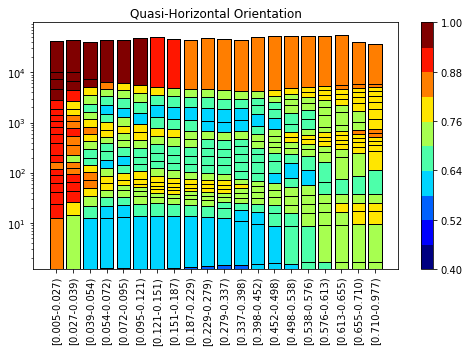

In [100]:
fig, ax = plt.subplots(figsize=(7,5))
cmap = plt.cm.jet
variable = avg_cplxs
norm = matplotlib.colors.Normalize(vmin=0.4, vmax=1.0)
bounds = np.linspace(0.4, 1.0, 11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):
        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r+1], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r]), 10),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r+1], color=cmap(norm(variable[i,r]), 10), edgecolor='k')

plt.yscale('log')
#plt.ylim(1.,10000)
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
#plt.ylabel("Aggregate Radius Bins")
#plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins")  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cb, orientation='vertical')
plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation')
plt.tight_layout()
#plt.savefig('../plots/bins_flat_meancplx.png', format='png', dpi=300)


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


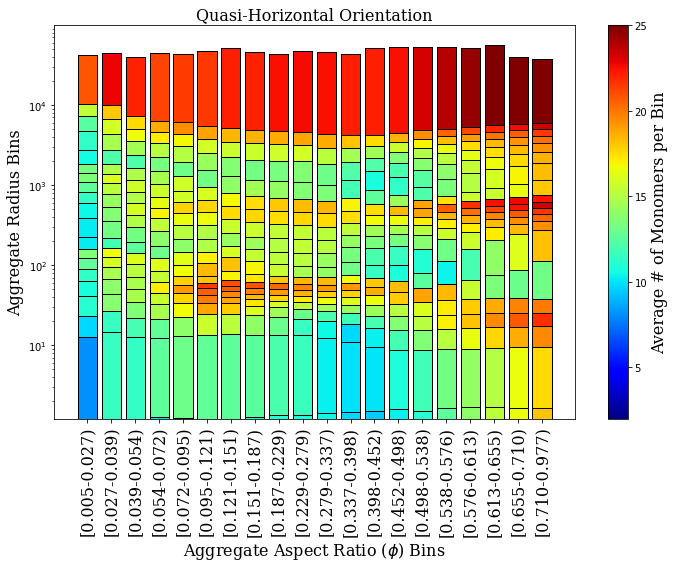

In [101]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
variable = avg_ncrystals

norm = matplotlib.colors.Normalize(vmin=2, vmax=25)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            if shape[i,r] == 'p': 
                plt.bar([i]*len(r_bins), all_r_bins[i,r+1], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
            else:
                 plt.bar([i]*len(r_bins), all_r_bins[i,r+1], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            if shape[i,r] == 'p':
                plt.bar([i]*len(r_bins), all_r_bins[i,r+1], color=cmap(norm(variable[i,r])), edgecolor='k')
            else:
                plt.bar([i]*len(r_bins), all_r_bins[i,r+1], color=cmap(norm(variable[i,r])), edgecolor='k')
                
    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, format='%d')
cbar.ax.set_ylabel('Average # of Monomers per Bin', fontsize=16, family='serif')
plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
#plt.title('Random Orientation',fontsize=16, family='serif')
plt.tight_layout()


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


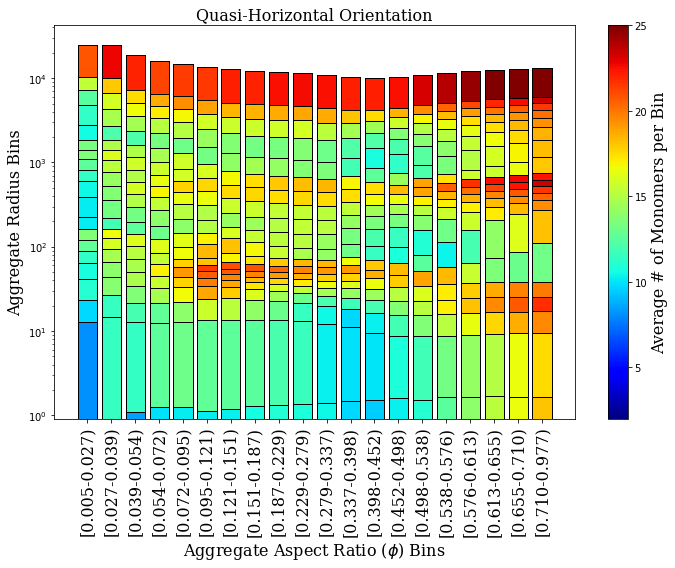

In [97]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
variable = avg_ncrystals

norm = matplotlib.colors.Normalize(vmin=2, vmax=25)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            if shape[i,r] == 'p': 
                plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
            else:
                 plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            if shape[i,r] == 'p':
                plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
            else:
                plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
                
    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, format='%d')
cbar.ax.set_ylabel('Average # of Monomers per Bin', fontsize=16, family='serif')
plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
#plt.title('Random Orientation',fontsize=16, family='serif')
plt.tight_layout()


[[0.01960784 0.18823529 0.38039216 1.        ]
 [0.07989235 0.30449827 0.54186851 1.        ]
 [0.14248366 0.41730104 0.68335256 1.        ]
 [0.21568627 0.51418685 0.73287197 1.        ]
 [0.32349097 0.61491734 0.78546713 1.        ]
 [0.50572857 0.73025759 0.84775087 1.        ]
 [0.65490196 0.81437908 0.89411765 1.        ]
 [0.7905421  0.88327566 0.93287197 1.        ]
 [0.88389081 0.92848904 0.95301807 1.        ]
 [0.96908881 0.96647443 0.96493656 1.        ]
 [0.96908881 0.96647443 0.96493656 1.        ]
 [0.99215686 0.85882353 0.78039216 1.        ]
 [0.95455594 0.64175317 0.50572857 1.        ]
 [0.83921569 0.37647059 0.30196078 1.        ]]
i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  


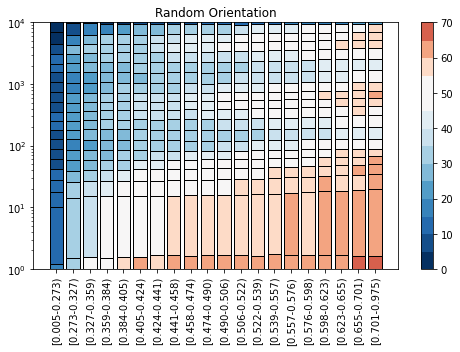

In [89]:
fig, ax = plt.subplots(figsize=(7,5))
#cmap = plt.cm.RdBu_r
cmap=discrete_cmap(14,'RdBu_r')
variable=agg_mono_phi
# norm = matplotlib.colors.Normalize(vmin=-max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))), \
#                                    vmax=max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))))
norm1 = matplotlib.colors.Normalize(vmin=0, vmax=70)
norm = matplotlib.colors.DivergingNorm(vmin=0, vcenter=50., vmax=70)
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
        if r != 0:
            plt.bar(i, all_r_bins[i,r], bottom= all_r_bins[i,r-1], color=cmap(norm(variable[i,r])), edgecolor='k')
        else:
            plt.bar(i, all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')

plt.yscale('log')
plt.ylim(1.,10000)
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
# plt.ylabel("Aggregate Radius Bins")
# plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",)  

cb = cm.ScalarMappable(cmap=cmap, norm=norm1)
cbar = plt.colorbar(cb, format='%d')
cbar.set_ticks(np.linspace(0,100,11))
          
#cbar.ax.set_ylabel('# of Oblates per Bin')
#plt.title('Quasi-Horizontal Orientation')
plt.title('Random Orientation');
#plt.tight_layout()
plt.tight_layout()
#plt.savefig('../plots/bins_flat_monophi.png', format='png',dpi=300)

[[0.01960784 0.18823529 0.38039216 1.        ]
 [0.07989235 0.30449827 0.54186851 1.        ]
 [0.14248366 0.41730104 0.68335256 1.        ]
 [0.21568627 0.51418685 0.73287197 1.        ]
 [0.32349097 0.61491734 0.78546713 1.        ]
 [0.50572857 0.73025759 0.84775087 1.        ]
 [0.65490196 0.81437908 0.89411765 1.        ]
 [0.7905421  0.88327566 0.93287197 1.        ]
 [0.88389081 0.92848904 0.95301807 1.        ]
 [0.96908881 0.96647443 0.96493656 1.        ]
 [0.96908881 0.96647443 0.96493656 1.        ]
 [0.99215686 0.85882353 0.78039216 1.        ]
 [0.95455594 0.64175317 0.50572857 1.        ]
 [0.83921569 0.37647059 0.30196078 1.        ]]
i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18


/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  


i=  19


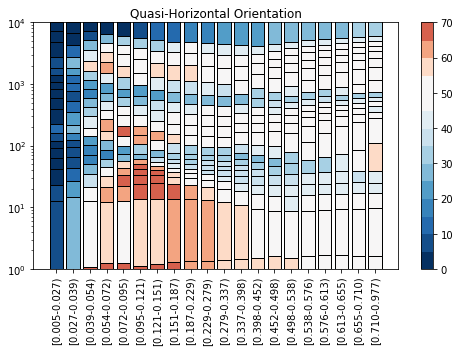

In [98]:
fig, ax = plt.subplots(figsize=(7,5))
#cmap = plt.cm.RdBu_r
cmap=discrete_cmap(14,'RdBu_r')
variable=agg_mono_phi
# norm = matplotlib.colors.Normalize(vmin=-max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))), \
#                                    vmax=max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))))
norm1 = matplotlib.colors.Normalize(vmin=0, vmax=70)
norm = matplotlib.colors.DivergingNorm(vmin=0, vcenter=50., vmax=70)
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
        if r != 0:
            plt.bar(i, all_r_bins[i,r], bottom= all_r_bins[i,r-1], color=cmap(norm(variable[i,r])), edgecolor='k')
        else:
            plt.bar(i, all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')

plt.yscale('log')
plt.ylim(1.,10000)
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
# plt.ylabel("Aggregate Radius Bins")
# plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",)  

cb = cm.ScalarMappable(cmap=cmap, norm=norm1)
cbar = plt.colorbar(cb, format='%d')
cbar.set_ticks(np.linspace(0,100,11))
          
#cbar.ax.set_ylabel('# of Oblates per Bin')
plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation');
#plt.tight_layout()
plt.tight_layout()
#plt.savefig('../plots/bins_flat_monophi.png', format='png',dpi=300)